## **Fine-tuning BERT for Slang BIO tagging**



In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install transformers datasets seqeval
%pip install matplotlib scikit-learn

In [23]:
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification
from datasets import load_dataset
from seqeval.metrics import classification_report
from torch.utils.data import Subset
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [24]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


#### **Preprocessing the data**

In [25]:
data = load_dataset("SohailaMohammed/BERTSlangIdentification")
# data.head()

In [26]:
total_size = sum(len(split) for split in data.values())
print(f"Total size of the dataset: {total_size}")

Total size of the dataset: 4035


In [27]:
data["train"][0]
data["train"][30]

{'sentence': 'I got a great deal through OA .',
 'word_labels': 'O,O,O,O,O,O,B,O'}

In [28]:
# Flatten and get unique labels, ignoring commas
all_labels = set(
    label
    for split in data.values()
    for row in split["word_labels"]
    for label in row.split(",") if label.strip()  # Ignore commas and empty strings
)

print(f"Unique labels in the dataset: {all_labels}")


Unique labels in the dataset: {'O', 'I', 'B'}


In [29]:
# Create dictionaries for label-to-ID mapping and vice versa
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print("label2id:", label2id)
print("id2label:", id2label)


label2id: {'O': 0, 'I': 1, 'B': 2}
id2label: {0: 'O', 1: 'I', 2: 'B'}


#### **Preparing the dataset and dataloader**

In [30]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 6
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

/home/sohaila/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BERT relies on wordpiece tokenization, rather than word tokenization, so we should define the labels at the wordpiece-level.

The function below propagates the word’s original label to all of its wordpieces.

In [31]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [32]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        print(self.data.features)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
    # step 1: Access data using `self.data[index]`
        row = self.data[index]  # Get the dictionary for this row
        sentence = row["sentence"]  # Access the sentence
        word_labels = row["word_labels"]  # Access the labels

        # Tokenize and preserve labels
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: Add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"]  # Add special tokens
        labels.insert(0, "O")  # Add outside label for [CLS] token
        labels.insert(-1, "O")  # Add outside label for [SEP] token

        # step 3: Truncating/padding
        maxlen = self.max_len

        if len(tokenized_sentence) > maxlen:
            # Truncate
            tokenized_sentence = tokenized_sentence[:maxlen]
            labels = labels[:maxlen]
        else:
            # Pad
            tokenized_sentence += ["[PAD]"] * (maxlen - len(tokenized_sentence))
            labels += ["O"] * (maxlen - len(labels))

        # step 4: Obtain the attention mask
        attn_mask = [1 if tok != "[PAD]" else 0 for tok in tokenized_sentence]

        # step 5: Convert tokens to input IDs
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(attn_mask, dtype=torch.long),
            "targets": torch.tensor(label_ids, dtype=torch.long),
        }


    def __len__(self):
        return self.len

In [33]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

#### **Defining the model**

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-large-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

#### **Training the model**



In [35]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [36]:
# Defining the training function on the 85% of the dataset for tuning the bert model
def train(epoch, training_loader):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

#### **Evaluating the model**

In [37]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    print(eval_labels)
    print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    print(labels)
    print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [38]:
test_dataset = data["test"]

# Tokenize the test dataset
test_data_var = dataset(test_dataset, tokenizer, MAX_LEN)

test_loader = DataLoader(test_data_var, batch_size=VALID_BATCH_SIZE, shuffle=False)

{'sentence': Value(dtype='string', id=None), 'word_labels': Value(dtype='string', id=None)}


#### **Cross-validation**

In [39]:
def cross_validate_k_folds(data, tokenizer, model, num_folds=5, epochs=EPOCHS):
    """
    Perform K-Fold cross-validation on the dataset with the specified number of folds.
    """
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    all_labels = []
    all_predictions = []

    dataset_var = dataset(data["train"], tokenizer, MAX_LEN)
    fold_results = []

    for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset_var)):
        print(f"Starting fold {fold + 1}/{num_folds}...")

        # Convert indices to Python int
        train_indices = [int(idx) for idx in train_indices]
        val_indices = [int(idx) for idx in val_indices]

        # Subset the dataset for training and validation
        train_subset = Subset(dataset_var, train_indices)
        val_subset = Subset(dataset_var, val_indices)

        # Create DataLoaders for training and validation
        train_loader = DataLoader(train_subset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=VALID_BATCH_SIZE, shuffle=False)

        # Reinitialize the model for each fold
        model = BertForTokenClassification.from_pretrained(
            'bert-large-uncased',
            num_labels=len(id2label),
            id2label=id2label,
            label2id=label2id,
        )
        model.to(device)

        # optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

        # Train the model
        for epoch in range(epochs):
            print(f"Training epoch: {epoch + 1} for fold {fold + 1}")
            train(epoch, train_loader)

        # Validate the model
        labels, predictions = valid(model, val_loader)

        # Collect results for this fold
        all_labels.extend(labels)
        all_predictions.extend(predictions)

        fold_results.append(classification_report(labels, predictions, output_dict=True))

    # Compute overall metrics
    print("Cross-validation completed. Here are the aggregated metrics:")
    print(classification_report(all_labels, all_predictions))

    return fold_results

In [40]:
fold_results = cross_validate_k_folds(data, tokenizer, model, num_folds=5, epochs=EPOCHS)

{'sentence': Value(dtype='string', id=None), 'word_labels': Value(dtype='string', id=None)}
Starting fold 1/5...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1 for fold 1
Training loss per 100 training steps: 1.114991307258606
Training loss per 100 training steps: 0.08006301284352742
Training loss per 100 training steps: 0.052971722875531785
Training loss per 100 training steps: 0.040568875258732776
Training loss per 100 training steps: 0.034049763327680456
Training loss per 100 training steps: 0.030049056912207245
Training loss per 100 training steps: 0.027376390044839306
Training loss epoch: 0.025777513202878514
Training accuracy epoch: 0.9313436714825966
Training epoch: 2 for fold 1
Training loss per 100 training steps: 0.002583801746368408
Training loss per 100 training steps: 0.011128548043146084
Training loss per 100 training steps: 0.010107754093892548
Training loss per 100 training steps: 0.009294778397024464
Training loss per 100 training steps: 0.009039002083903272
Training loss per 100 training steps: 0.009025230885661317
Training loss per 100 training steps: 0.008888912021433128
Training loss epoch: 0.00892343465

/home/sohaila/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1 for fold 2
Training loss per 100 training steps: 0.0038015334866940975
Training loss per 100 training steps: 0.0024449868956478464
Training loss per 100 training steps: 0.0035636195807455806
Training loss per 100 training steps: 0.0035672162071672836
Training loss per 100 training steps: 0.0035010094192434475
Training loss per 100 training steps: 0.0033066919250612447
Training loss per 100 training steps: 0.0034595948506925644
Training loss epoch: 0.003511044126103765
Training accuracy epoch: 0.990105762183195
Training epoch: 2 for fold 2
Training loss per 100 training steps: 0.0017814944731071591
Training loss per 100 training steps: 0.0013234665383705679
Training loss per 100 training steps: 0.001282196717235381
Training loss per 100 training steps: 0.0013803527460497986
Training loss per 100 training steps: 0.001300082127712622
Training loss per 100 training steps: 0.0011414218873254643
Training loss per 100 training steps: 0.0011706569429658163
Training loss epoch

/home/sohaila/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1 for fold 3
Training loss per 100 training steps: 2.870240859920159e-05
Training loss per 100 training steps: 0.0016114182408070727
Training loss per 100 training steps: 0.0012699802537088146
Training loss per 100 training steps: 0.001091673852733736
Training loss per 100 training steps: 0.0011696229267231604
Training loss per 100 training steps: 0.0011459908459570132
Training loss per 100 training steps: 0.0010806008041611837
Training loss epoch: 0.0010853447536274968
Training accuracy epoch: 0.9970895432451705
Training epoch: 2 for fold 3
Training loss per 100 training steps: 3.5100823879474774e-05
Training loss per 100 training steps: 0.0005960941828399683
Training loss per 100 training steps: 0.0004477520132652659
Training loss per 100 training steps: 0.0007839971592005763
Training loss per 100 training steps: 0.0007618215611642187
Training loss per 100 training steps: 0.0007279872211075053
Training loss per 100 training steps: 0.0006876515432975887
Training loss e

/home/sohaila/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1 for fold 4
Training loss per 100 training steps: 6.124129868112504e-05
Training loss per 100 training steps: 0.000884595318585426
Training loss per 100 training steps: 0.0011941694307635808
Training loss per 100 training steps: 0.0013895320288961905
Training loss per 100 training steps: 0.0012882641097126553
Training loss per 100 training steps: 0.001119976167262871
Training loss per 100 training steps: 0.0010039471483328807
Training loss epoch: 0.000985319361953935
Training accuracy epoch: 0.9977026603070649
Training epoch: 2 for fold 4
Training loss per 100 training steps: 1.3051654605078511e-05
Training loss per 100 training steps: 0.0001821246605641586
Training loss per 100 training steps: 0.0001957181630369809
Training loss per 100 training steps: 0.00019469962827478777
Training loss per 100 training steps: 0.00024289313408987987
Training loss per 100 training steps: 0.00027507710014943
Training loss per 100 training steps: 0.0002962578842455086
Training loss epo

/home/sohaila/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1 for fold 5
Training loss per 100 training steps: 7.247985536196211e-07
Training loss per 100 training steps: 0.00019914188125355422
Training loss per 100 training steps: 0.00035015393742600533
Training loss per 100 training steps: 0.0004856880186541526
Training loss per 100 training steps: 0.00047354618680020436
Training loss per 100 training steps: 0.0007660395143704841
Training loss per 100 training steps: 0.0007427444528338175
Training loss epoch: 0.0006964723639445152
Training accuracy epoch: 0.9984194103246545
Training epoch: 2 for fold 5
Training loss per 100 training steps: 8.832809726300184e-06
Training loss per 100 training steps: 0.0003853950163982806
Training loss per 100 training steps: 0.0004667275205555195
Training loss per 100 training steps: 0.0003588732259181008
Training loss per 100 training steps: 0.00042727759351553576
Training loss per 100 training steps: 0.0004605689623849049
Training loss per 100 training steps: 0.0004178977784974454
Training lo

#### **Evaluating the model on the test set**

In [41]:
# Final evaluation on the test dataset
print("\n=== Final Test Evaluation ===")
true_labels, predictions = valid(model, test_loader)
print(classification_report(true_labels, predictions))



=== Final Test Evaluation ===
Validation loss per 100 evaluation steps: 4.367865074073052e-07
Validation loss per 100 evaluation steps: 0.012776152003702423
Validation loss per 100 evaluation steps: 0.013641308896318977
Validation loss per 100 evaluation steps: 0.016403620683386716
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devic

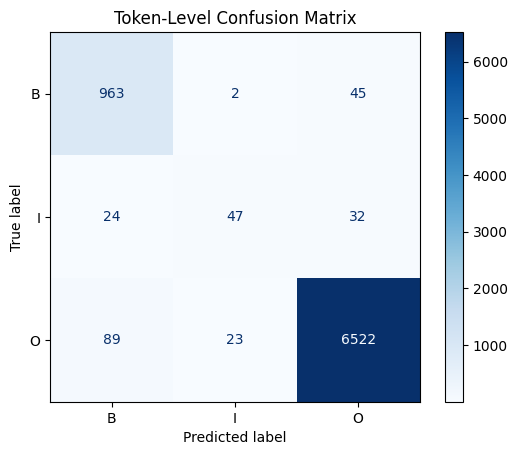

In [42]:
unique_labels = ["B","I","O"]

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=unique_labels)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Token-Level Confusion Matrix")
plt.show()

#### **Saving the model in huggingface**

In [ ]:
model_name = "bert-slang-bio"

# Upload the tokenizer to the hub
tokenizer.push_to_hub(
    repo_id=model_name,
    commit_message="Add tokenizer",
    use_temp_dir=True,
)

# Upload the model to the hub
model.push_to_hub(
    repo_id=model_name,
    commit_message="Add model",
    use_temp_dir=True,
)
